In [15]:
# Is it sweet or savory - food images
# we'll get representative foods from different cuisines and see how it does

#hide
import fastbook
fastbook.setup_book()

In [16]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [17]:
from fastdownload import download_url
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Searching for 'fast food'
['https://api.time.com/wp-content/uploads/2015/09/burger.jpg', 'https://www.fastfoodmenunutrition.com/wp-content/uploads/2015/03/fast-food.jpg', 'http://photos.demandstudios.com/getty/article/176/236/513067186.jpg', 'https://braincharm.com/wp-content/uploads/2018/04/Burger-and-Fries.jpg', 'https://imgix.kotaku.com.au/content/uploads/sites/3/2021/01/11/burger-kfc.jpg?auto=format&fit=fill&q=65&w=1280']


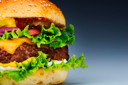

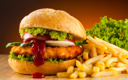

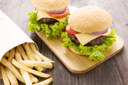

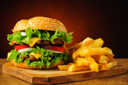

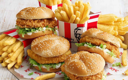

In [27]:
results = search_images('fast food', max_images=5)
print(results)
for i in range(5):
    dest = f'temp/food{i}.jpg'
    download_url(results[i], dest)
    display(Image.open(dest).to_thumb(128,128))

In [66]:
sweet_foods = 'cakes', 'cookies', 'ice cream', 'pies', 'puddings', 'candy', 'soda', 'dessert', 'fruit'
savory_foods = 'dinner food', 'lunch food', 'sandwiches', 'pizza', 'casseroles', 'chips', 'crisps', 'fast food', 'pasta meals'
food_types = 'sweet', 'savory'
basedir = 'food_images'
for t in *food_types, basedir:
    print(f'making dir {t}')
    path = Path(t)
    if not path.exists():
        path.mkdir(exist_ok=True)


making dir sweet
making dir savory
making dir food_images


In [67]:
n_images = 60
dest = basedir + '/sweet'
for f in sweet_foods:
    print(f'downloading {f} into {dest}')
    results = search_images(f, max_images=n_images)
    download_images(dest, urls=results)
    
dest = basedir + '/savory'
for f in savory_foods:
    print(f'downloading {f} into {dest}')
    results = search_images(f, max_images=n_images)
    download_images(dest, urls=results)
    
print('done downloading data')

downloading cakes into food_images/sweet
Searching for 'cakes'
downloading cookies into food_images/sweet
Searching for 'cookies'
downloading ice cream into food_images/sweet
Searching for 'ice cream'
downloading pies into food_images/sweet
Searching for 'pies'
downloading puddings into food_images/sweet
Searching for 'puddings'
downloading candy into food_images/sweet
Searching for 'candy'
downloading soda into food_images/sweet
Searching for 'soda'
downloading dessert into food_images/sweet
Searching for 'dessert'
downloading fruit into food_images/sweet
Searching for 'fruit'
downloading dinner food into food_images/savory
Searching for 'dinner food'
downloading lunch food into food_images/savory
Searching for 'lunch food'
downloading sandwiches into food_images/savory
Searching for 'sandwiches'
downloading pizza into food_images/savory
Searching for 'pizza'
downloading casseroles into food_images/savory
Searching for 'casseroles'
downloading chips into food_images/savory
Searching f

Our folder has image files, as we'd expect:

In [68]:
path = Path(basedir)
images = get_image_files(path)
failed = verify_images(images)
failed
failed.map(Path.unlink);

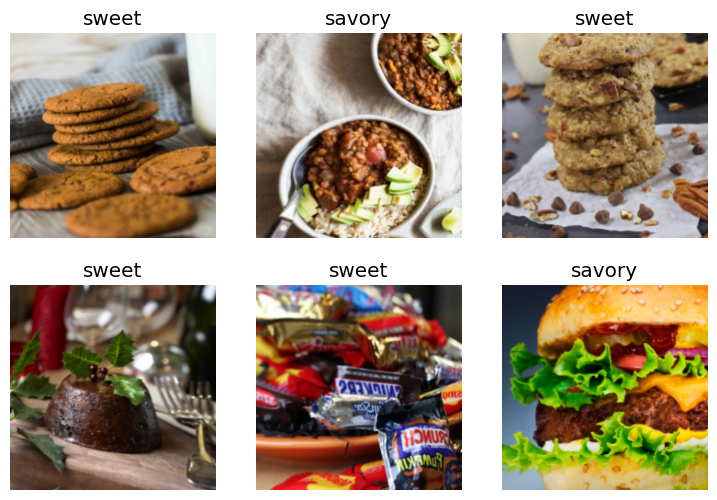

In [69]:
foods = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=69),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

dls = foods.dataloaders(path)
dls.show_batch(max_n=6)

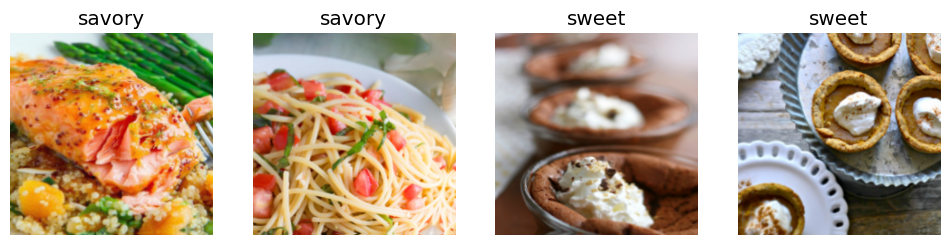

In [70]:
dls.train.show_batch(max_n=4, nrows=1)

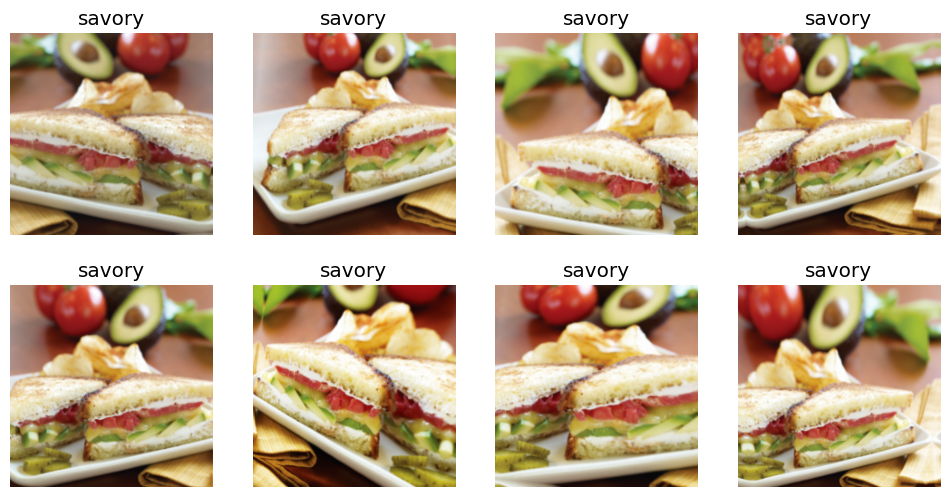

In [41]:
# run this to try different data augmentation techniques
# foods = foods.new(
#     item_tfms=RandomResizedCrop(224, min_scale=0.5),
#     batch_tfms=aug_transforms())
# dls = foods.dataloaders(path)
# dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [71]:
from fastai.vision.all import *
#weights=ResNet18_Weights.DEFAULT
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

# epoch	train_loss	valid_loss	error_rate	time
# 0	1.132646	0.370783	0.186047	01:30
# epoch	train_loss	valid_loss	error_rate	time
# 0	0.441018	0.314932	0.147287	01:39
# 1	0.351603	0.276066	0.124031	01:39
# 2	0.298964	0.265094	0.093023	01:39
# 3	0.241824	0.238546	0.062016	01:49
# 4	0.199377	0.209874	0.069767	01:40
# 5	0.166986	0.177533	0.069767	01:55

# with more data, 3 tunes would have been enough:
# epoch	train_loss	valid_loss	error_rate	time
# 0	0.398574	0.276597	0.098039	02:42
# 1	0.309318	0.249865	0.078431	02:43
# 2	0.236214	0.199368	0.053922	02:46
# 3	0.191409	0.179920	0.053922	02:29

epoch,train_loss,valid_loss,error_rate,time
0,0.848889,0.420151,0.147059,02:36


/Users/dphung/mambaforge/envs/fastbook/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.398574,0.276597,0.098039,02:42
1,0.309318,0.249865,0.078431,02:43
2,0.236214,0.199368,0.053922,02:46
3,0.191409,0.179920,0.053922,02:29


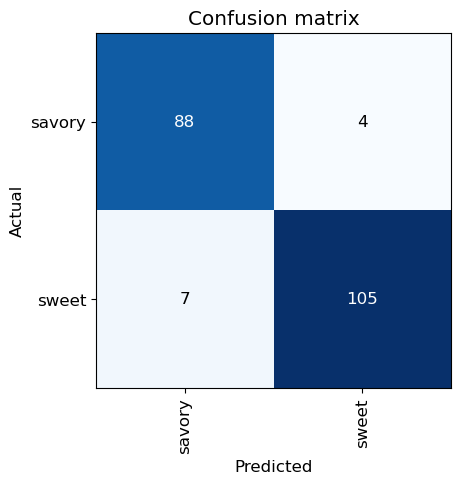

In [73]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

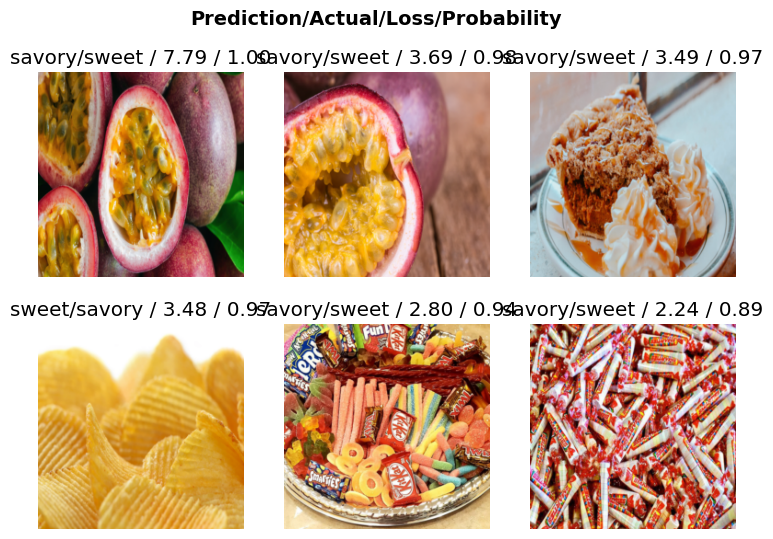

In [77]:
interp.plot_top_losses(6, nrows=2)

In [78]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

/Users/dphung/mambaforge/envs/fastbook/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [84]:
print(type(learn.dls.vocab))

<class 'fastai.data.transforms.CategoryMap'>


In [52]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [76]:
filename = 'foods.pkl'
learn.export(filename)

Let's check that the file exists, by using the `ls` method that fastai adds to Python's `Path` class:

In [45]:
path = Path()
path.ls(file_exts='.pkl')

(#2) [Path('export.pkl'),Path('bears.pkl')]

You'll need this file wherever you deploy your app to. For now, let's try to create a simple app within our notebook.

When we use a model for getting predictions, instead of training, we call it *inference*. To create our inference learner from the exported file, we use `load_learner` (in this case, this isn't really necessary, since we already have a working `Learner` in our notebook; we're just doing it here so you can see the whole process end-to-end):

In [47]:
learn_inf = load_learner(path/filename)

When we're doing inference, we're generally just getting predictions for one image at a time. To do this, pass a filename to `predict`:

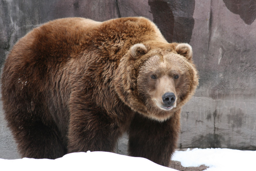

('grizzly', TensorBase(1), TensorBase([6.0048e-06, 9.9997e-01, 1.9411e-05]))

In [49]:
display(Image.open('images/grizzly.jpg').to_thumb(256,256))
learn_inf.predict('images/grizzly.jpg')

In [50]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']